### Detecting suicide ideation in online posts from Twitter using Machine Learning classifiers

In [1]:
!pip install  unidecode

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
# AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle
import string
import re
import unidecode

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
df = pd.read_csv('Suicide_Ideation_Twitter.csv',encoding='utf-8',engine='python')

print(df.shape)

# df = df.sample(6000, random_state=47)
# df.drop('Unnamed: 0', axis=1,inplace=True)
df.head()

(1787, 2)


Tweet                  Suicide
0                                  making some lunch         Not Suicide post
1                        @Alexia You want his money.         Not Suicide post
2  @dizzyhrvy that crap took me forever to put to...  Potential Suicide post 
3  @jnaylor #kiwitweets Hey Jer! Since when did y...         Not Suicide post
4  Trying out &quot;Delicious Library 2&quot; wit...         Not Suicide post

In [4]:
df.rename(columns={'Tweet':'text','Suicide':'class'},inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1785 non-null   object
 1   class   1787 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB


In [6]:
df['text'] = df['text'].astype(str)
df['class'] = df['class'].astype(str)
df['text'] = df['text'].str.lower()
df['class'] = df['class'].str.lower()

In [7]:
df.reset_index(inplace=True,drop=True)

In [8]:
df[df['text'].isnull()].index

Int64Index([], dtype='int64')

In [9]:
df.to_csv('suicide_detection_twitter_modified.csv')

In [10]:
def rem_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

def rem_url(text):
    return re.sub(r'http\S+', '', text)

def rem_email(text):
    return re.sub(r'\S+@\S+', '', text)

def rem_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

def rem_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def rem_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

def rem_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def fix_lengthening(text):
     return re.sub(r"(.)\1{2,}",r'\1',text)


In [11]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Looking at a sample tweet
df['text'][30]

"@domselinakyle that sounds so terrible that's how i was when my dad still lived w me but i hope it gets better forâ\x80¦ https://t.co/oah2tunbxt"

In [13]:
df['text']   = df['text'].apply(lambda t : rem_emoji(t))
df['text']   = df['text'].apply(lambda t : rem_symbols_digits(t))
df['text']   = df['text'].apply(lambda t : rem_url(t))
df['text']   = df['text'].apply(lambda t : rem_email(t))
df['text']   = df['text'].apply(lambda t : rem_special(t))
df['text']   = df['text'].apply(lambda t : rem_accented_chars(t))
df['text']   = df['text'].apply(lambda t : fix_lengthening(t))
df['text']   = df['text'].apply(lambda t : rem_whitespace(t))

In [14]:
df['text'][30]

'domselinakyle that sounds so terrible that s how i was when my dad still lived w me but i hope it gets better for t co oah tunbxt'

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

In [18]:
df['text'][30]

['domselinakyle',
 'sounds',
 'terrible',
 'dad',
 'still',
 'lived',
 'w',
 'hope',
 'gets',
 'better',
 'co',
 'oah',
 'tunbxt']

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
wl = WordNetLemmatizer()

In [21]:
df['text'] = df['text'].apply(lambda x: [wl.lemmatize(i) for i in x])

In [22]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [23]:
df.to_csv('suicide_clean.csv')

In [24]:
# from sklearn.preprocessing import LabelEncoder

# le=LabelEncoder()

# df['class']=le.fit_transform(df['class'])

In [25]:
!pip install vaderSentiment

In [26]:
# Importing Vader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent_analyser = SentimentIntensityAnalyzer()

num_rows = df.shape[0]
score_vector = []
for i in range(num_rows):
    score = sent_analyser.polarity_scores(df.loc[i,'text'])
    print(score)
    score_vector.append(score['compound'])


df.loc[:,'sentiment'] = score_vector
df

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.0772}
{'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'compound': -0.3818}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.739, 'pos': 0.261, 'compound': 0.7184}
{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.296}
{'neg': 0.108, 'neu': 0.892, 'pos': 0.0, 'compound': -0.1779}
{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'compound': -0.0516}
{'neg': 0.493, 'neu': 0.188, 'pos': 0.319, 'compound': -0.5719}
{'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'compound': 0.5859}
{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.6124}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.293, 'neu': 0.707, 'pos': 0.0, 'compound': -0.6597}
{'neg': 0.0, 'neu': 0.541, 'pos': 0.459, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.2732}
{'neg': 0.352, 'neu': 0.584, 'pos': 0.063

{'neg': 0.248, 'neu': 0.246, 'pos': 0.507, 'compound': 0.7404}
{'neg': 0.481, 'neu': 0.3, 'pos': 0.22, 'compound': -0.3843}
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6369}
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.4588}
{'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'compound': 0.8442}
{'neg': 0.248, 'neu': 0.752, 'pos': 0.0, 'compound': -0.5106}
{'neg': 0.337, 'neu': 0.663, 'pos': 0.0, 'compound': -0.6808}
{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}
{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.296}
{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.0772}
{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.0772}
{'neg': 0.532, 'neu': 0.321, 'pos': 0.147, 'compound': -0.7906}
{'neg': 0.0, 'neu': 1.

{'neg': 0.474, 'neu': 0.37, 'pos': 0.156, 'compound': -0.6486}
{'neg': 0.122, 'neu': 0.687, 'pos': 0.191, 'compound': 0.2263}
{'neg': 0.718, 'neu': 0.282, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.406, 'neu': 0.476, 'pos': 0.118, 'compound': -0.9739}
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.3612}
{'neg': 0.108, 'neu': 0.703, 'pos': 0.19, 'compound': 0.7713}
{'neg': 0.209, 'neu': 0.33, 'pos': 0.462, 'compound': 0.5106}
{'neg': 0.0, 'neu': 0.394, 'pos': 0.606, 'compound': 0.8271}
{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'compound': 0.3818}
{'neg': 0.125, 'neu': 0.573, 'pos': 0.302, 'compound': 0.5267}
{'neg': 0.0, 'neu': 0.64, 'pos': 0.36, 'compound': 0.6697}


text  \
0                                          making lunch   
1                                     alexia want money   
2     dizzyhrvy crap took forever put together going...   
3     jnaylor kiwitweets hey jer since start twittering   
4     trying quot delicious library quot mixed resul...   
...                                                 ...   
1782                        forgotten much love nokia n   
1783  starting day positive attitude great watch gre...   
1784              belledame hey give girl credit trying   
1785  drunken besties stumble room run around sober ...   
1786  dancingbonita quot friggin love quot ron burgu...   

                        class  sentiment  
0            not suicide post     0.0000  
1            not suicide post     0.0772  
2     potential suicide post     -0.3818  
3            not suicide post     0.0000  
4            not suicide post     0.7184  
...                       ...        ...  
1782         not suicide post     0.5106  
1783         not suicide post     0.8271  
1784         not suicide post     0.3818  
1785         not suicide post     0.5267  
1786         not suicide post     0.6697  

[1787 rows x 3 columns]

In [27]:
sent_analyser.polarity_scores("I have lost all my savings ! How will life go on!")

sent_analyser.polarity_scores("Tomorrow I am starting a new job. Feeling Good")

sent_analyser.polarity_scores("I am going to visit my Mom tomorrow")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [28]:
#### Combining ML classifiers with VADER 

# Dropping the original class variable
df.drop(columns=['class'],inplace=True)

In [29]:
# Creating a new class variable

for i in range(df.shape[0]) :
    
    if df.loc[i,'sentiment'] < 0.05 :
# Non suicide        
        df.loc[i,'class'] = 0
# Suicidal intent        
    else :
        df.loc[i,'class'] = 1

In [30]:
df['class'].value_counts(normalize=True)

0.0    0.523783
1.0    0.476217
Name: class, dtype: float64

In [31]:
X = df['text']
y = df['class']

In [32]:
vectorizer = TfidfVectorizer(min_df=50,max_features=6000,ngram_range=(1,2))
x =  vectorizer.fit_transform(X).toarray()

In [33]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

X_train.shape,X_test.shape

((1250, 40), (537, 40))

In [34]:
def model_accuracy (clf,train,test,target_train,target_test):

    clf.fit(train,target_train)

    y_pred = clf.predict(test)

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='summer')
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.64      0.69       283
         1.0       0.65      0.76      0.70       254

    accuracy                           0.70       537
   macro avg       0.70      0.70      0.70       537
weighted avg       0.70      0.70      0.70       537



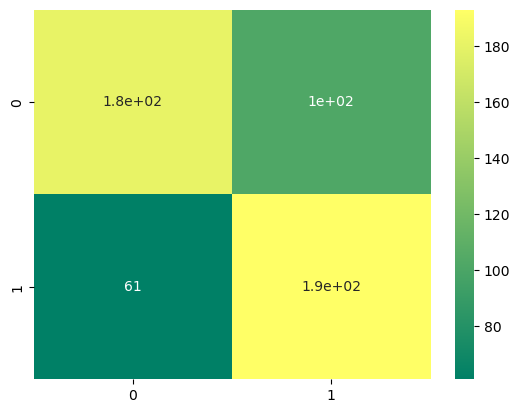

In [35]:
lr_clf = LogisticRegression(random_state=42)

model_accuracy(lr_clf,X_train,X_test,y_train,y_test)

              precision    recall  f1-score   support

         0.0       0.77      0.59      0.67       283
         1.0       0.64      0.80      0.71       254

    accuracy                           0.69       537
   macro avg       0.71      0.70      0.69       537
weighted avg       0.71      0.69      0.69       537



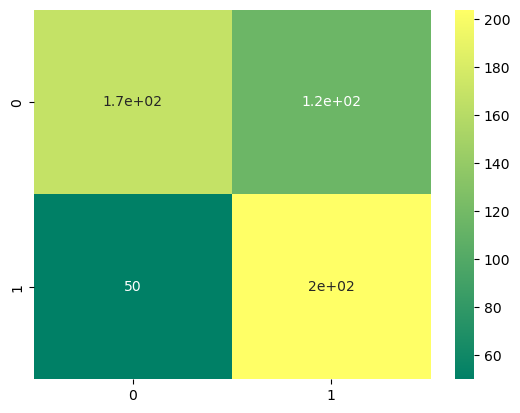

In [36]:
nb_clf = BernoulliNB()

model_accuracy(nb_clf,X_train,X_test,y_train,y_test)

#### Decision Tree Classifier

In [37]:
dt = DecisionTreeClassifier()

params_dt = {
'min_samples_split': range(1,10),
'criterion':['gini','entropy'],
'max_depth': range(1,10),
'min_samples_leaf': range(1,5)
}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring= 'r2',
cv=5,
n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract best model from 'grid_dt'
best_modelDT = grid_dt.best_params_

In [38]:
DT_final = DecisionTreeClassifier(**best_modelDT)

              precision    recall  f1-score   support

         0.0       0.88      0.51      0.65       283
         1.0       0.63      0.93      0.75       254

    accuracy                           0.71       537
   macro avg       0.76      0.72      0.70       537
weighted avg       0.76      0.71      0.70       537



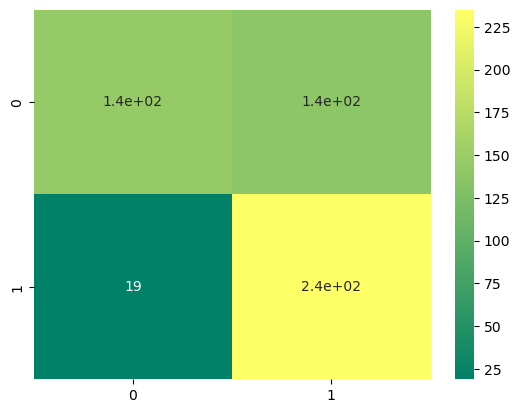

In [39]:
model_accuracy(DT_final,X_train,X_test,y_train,y_test)

#### RandomForest Classifier

In [40]:
rf_model = RandomForestClassifier()


# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20,40,50,100,150],
    max_depth=[5, 10, 15],
    min_samples_split=[2, 4,5],
    criterion = ['gini', 'entropy'],
#     max_features= ['auto', 'sqrt', 'log2']
)

# search
rf_clf = GridSearchCV(rf_model, rf_param_grid,
                   scoring='r2', cv=5, n_jobs = -1,verbose=1)

rf_clf.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [10, 20, 40, 50, 100, 150]},
             scoring='r2', verbose=1)

In [41]:
best_modelRF = rf_clf.best_params_

In [42]:
rf_final = RandomForestClassifier(**best_modelRF)

              precision    recall  f1-score   support

         0.0       0.84      0.58      0.69       283
         1.0       0.65      0.87      0.75       254

    accuracy                           0.72       537
   macro avg       0.75      0.73      0.72       537
weighted avg       0.75      0.72      0.72       537



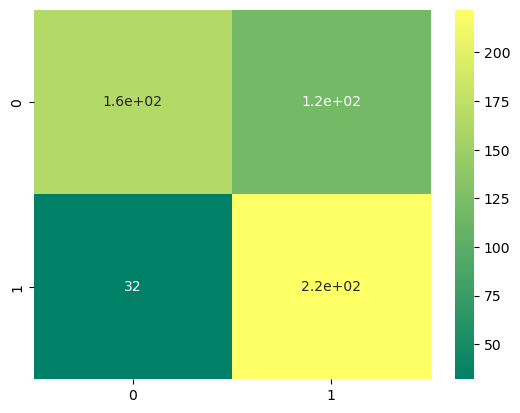

In [43]:
model_accuracy(rf_final,X_train,X_test,y_train,y_test)

#### XGBoost Classifier

In [44]:
param_dist = {
        'n_estimators':range(50,150,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,1,25),
        'subsample':np.linspace(0.1,0.9,25),
        'colsample_bytree':np.linspace(0.3,0.8,20),
        'min_child_weight':range(1,9,1),
        'gamma': [0, 0.2,0.25, 0.3,0.35, 0.5, 1.0]

        }


xgbr = XGBClassifier()
XGB_Model = RandomizedSearchCV(xgbr,
                   param_dist,
                   scoring='r2',
                   verbose=1,
                    cv = 5,
                    n_iter=125,
                    n_jobs = -1)
XGB_Model.fit(X_train, y_train)
print("Best parameters:", XGB_Model.best_params_)

best_modelXGB = XGB_Model.best_params_



Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best parameters: {'subsample': 0.33333333333333337, 'n_estimators': 95, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.051250000000000004, 'gamma': 0.3, 'colsample_bytree': 0.5631578947368421}


In [45]:
xgb_final = XGBClassifier(**best_modelXGB)

              precision    recall  f1-score   support

         0.0       0.77      0.58      0.66       283
         1.0       0.63      0.81      0.71       254

    accuracy                           0.69       537
   macro avg       0.70      0.70      0.69       537
weighted avg       0.71      0.69      0.69       537



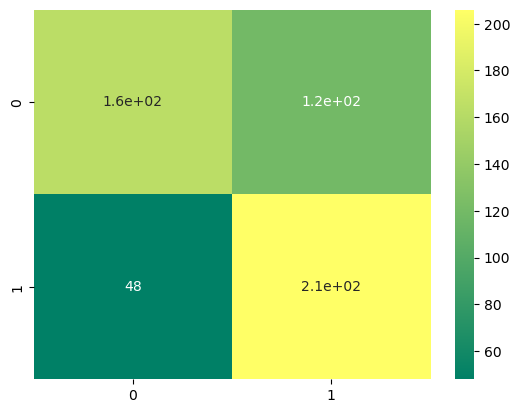

In [46]:
model_accuracy(xgb_final,X_train,X_test,y_train,y_test)